In [9]:
%run -i ../init.py
%run -i ../13/onekg.py

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

# Lecture 14
## The pairwise sequentially Markovian coalescent

In this lecture we will learn how to estimate the historical size of a population using diploid genotype data.

![psmc1](https://www.researchgate.net/profile/Wenping_Zhang/publication/264391030/figure/fig4/AS:295980604903429@1447578683786/Pairwise-sequential-Markovian-coalescent-PSMC-analysis-of-nine-Chinese-wolf-genomes.png)

![psmc2](https://onlinelibrary.wiley.com/cms/asset/3de2a91b-b1b7-45c1-b680-5f84189e5e95/mec13540-fig-0008-m.jpg)

![psmc3](https://www.biorxiv.org/content/biorxiv/early/2020/03/05/2020.03.03.962365/F5.large.jpg)

## Modeling variable population size
Suppose that the population size fluctuates over time according to some function $N_e(s)$. In the W-F model, the probability of no coalescence $t$ generations back would be
$$\prod_{s=0}^{t} \Big(1-\frac{1}{2N_e(s)}\Big) \approx \exp\Big(-\sum_{s=0}^t \frac{1}{2N_e(s)} \Big) \approx \exp \Big(-\int_0^t \frac{ds}{2N_e(s)} \Big) $$

Thus, if we let $R(t)=\int_0^t [2N_e(s)]^{-1}$, then the pdf of pairwise coalescent times under such a model is 

$$f_T(t) = \frac{e^{-R(t)}}{2N_e(t)}.$$

To simulate from this distribution, we can draw $Z\sim \mathrm{Exp}(1)$, and find $T$ such that

$$Z = R(T).$$

This is a simple consequence of the inversion method:

$$
\mathbb{P}(T>t) = \mathbb{P}(R(T)>R(t)) = \mathbb{P}(Z>R(t)) = e^{-R(t)}.
$$

For $n$ samples we proceed as in the constant size case: the first coalescent time is distributed 

$$\mathbb{P}(T_n>t) = \exp\Big\{-\binom{n}{2}R(t)\Big\},$$

and subsequent times are found by solving

$$T_k \mid T_{k+1} : Z = \int_{T_{k}}^{T_{k+1}} \binom{k}{2}R(t)\,dt.$$

## Inferring $N_e(t)$
If we could sample directly from $f_T(t)$ then inferring $N_e(t)$ would be easy, essentially amounting to a density estimation problem.

In [45]:
import msprime as msp

de = [
    msp.PopulationParametersChange(time=0, growth_rate=1e-4, initial_size=1e6),
    msp.PopulationParametersChange(time=1000, growth_rate=0, initial_size=1e4),
]
tmrca = np.log(
    [
        [
            r.first().get_time(2)
            for r in msp.simulate(
                sample_size=2, demographic_events=d, num_replicates=10000
            )
        ]
        for d in ([], de)
    ]
)

<IPython.core.display.Javascript object>

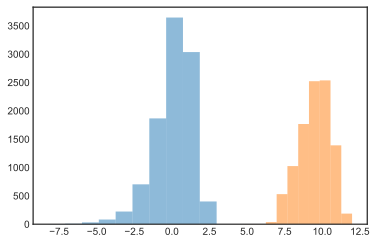

<IPython.core.display.Javascript object>

In [46]:
for t in tmrca:
    plt.hist(t, alpha=0.5)

Unfortunately, life is not that great. We only get to observe mutations, and from those, we have to guess about what the distribution of the underlying trees is.

Concretely, the raw data looks like:

In [54]:
msp.simulate(
    sample_size=20, length=1e5, mutation_rate=1e-4, recombination_rate=1e-4
).genotype_matrix()[:, :2].sum(1) % 2

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

## PSMC
The pairwise sequentially Markov coalescent tackles this problem using a coalescent hidden Markov model. The latent states of the HMM are the tree heights at each position, and the observed data is whether or not there is a mutation at each position.

![psmc schematic](https://pbs.twimg.com/media/EjBluTnWoAcx25c?format=jpg&name=large)

Let $\pi(\cdot)$ be the distribution of a pairwise TMRCA in our population. (Above we denoted this as $f_T(t)$, but to remain consistent with the standard HMM notation, I will call it $\pi(\cdot)$ from now on.)


The generative model for PSMC is similar to the one we learned back in lecture 5 for simulating whole genome data. 
\begin{align}
X_1 &\sim \pi(x)\\
Y_n \mid X_n & \sim \mathrm{Poisson}(\theta X_n)\\
X_{n+1}\mid X_n &\sim q_\pi^{\text{SMC}}(x_{n+1}\mid x_n)
\end{align}

where $q_\text{SMC}$ is the probability density of the sequentially Markov coalescent model that we covered earlier.

## Discretization
To use this model for inference, we want to use an HMM. The main difficulty is that the state space of our model (the support of the $X_n$) is continuous, whereas it must be discrete for an HMM. So, we will discretize time such that

$$0=t_0<t_1<\cdots<t_M<t_{M+1}=\infty,$$

and consider hidden state $m$ to be such that $X_n \in [t_m,t_{m+1})$.

This leads to tedious and uninteresting calculations, i.e. 

$$A_{ij}=\mathbb{P}(X_{n+1} \in [t_j,t_{j+1}) \mid X_n \in [t_i,t_{i+1}) = 
\frac{
\int_{t_j}^{t_{j+1}} \int_{t_i}^{t_{i+1}} q_\pi^{\text{SMC}}(t\mid s) \pi(s)\,ds\,dt
}{
\int_{t_i}^{t_{i+1}} \pi(s)\,ds}
$$

## Inferring $\pi$
Using the techniques we learned last lecture, we can compute

$$\mathbb{P}_\pi(X_{1:N}) = \int_{Y_{1:N}} \mathbb{P}_\pi(X_{1:N},Y_{1:N}).$$

efficiently. However, it turns out to be better to use E-M.

## E-M for HMMs
Recall from last lecture that the complete log-likelihood for the observations $X_{1:N}$ and hidden variables $Y_{1:N}$ is 

$$\mathbb{P}_\pi(X_{1:N},Y_{1:N}) = \pi(X_1) \prod_{n=1}^N \mathbb{P}(Y_i\mid X_i) \prod_{n=2}^N q_\pi^\text{SMC}(X_n \mid X_{n-1}).$$

Define the so-called $Q$ function by 

$$Q(\pi,\pi^{\text{old}}) = \mathbb{E}_{X_{1:N} \mid Y_{1:N},\pi^{\text{old}}} \log \mathbb{P}_\pi(X_{1:N},Y_{1:N}).$$

Note that the conditional expectation is with respect to $\pi^{\text{old}}$, while the complete loglik is with respect to $\pi$.

Given the posterior decoding $\gamma_i = \mathbb{P}(X_i \mid Y_{1:N}) \in \mathbb{R}^M,i=1,\dots,N$ which we computed using $\pi^{\text{old}}$, we have

\begin{align}
\mathbb{E}_{X_{1:N} \mid Y_{1:N},\pi^{\text{old}}} \log \pi(X_1) &= \sum_{i=1}^M \gamma_1(i) \log \pi_i \\
\mathbb{E}_{X_{1:N} \mid Y_{1:N},\pi^{\text{old}}} \log \mathbb{P}(Y_i\mid X_i) &= \sum_{j=1}^M \gamma_i(j) \log \mathbb{P}(Y_i\mid X_i) \\
\end{align}

The final quantity we need is the expected number of transitions from state $i$ to state $j$:

$$\mathbb{E}_{X_{1:N} \mid Y_{1:N},\pi^{\text{old}}} \log q_\pi^{\text{SMC}}(X_j \mid X_{j-1})$$

To compute this we require the posterior $\mathbb{P}(X_i,X_{i+1} \mid Y_{1:N})$. We can derive this from the forward-backward algorithm as well:

\begin{align}
\mathbb{P}(X_i,X_{i+1} \mid Y_{1:N}) &= 
\frac{\mathbb{P}(X_i,X_{i+1},Y_{1:N})}{\mathbb{P}(Y_{1:N})} \\ &=
\frac{\mathbb{P}(Y_i\mid X_i) \mathbb{P}(X_{i+1}\mid X_i)\mathbb{P}(X_i,Y_{1:i})\mathbb{P}(Y_{i+1:N}\mid X_{i+1})}
{\mathbb{P}(Y_{1:N})}
\\ 
&= \frac{\hat{\alpha}(X_i) B_i T \hat{\beta}(X_{i+1})^T}{c_{n}}.
\end{align}

## Application to real data

In [57]:
import tskit

chr22 = tskit.load("../13/1kg_chr22.trees")
long_spans = [t.interval for t in chr22.trees() if np.diff(t.interval) > 1e5]

<IPython.core.display.Javascript object>

In [17]:
chr22_filter = chr22.delete_intervals(long_spans, simplify=False).trim()

<IPython.core.display.Javascript object>

In [67]:
pops, superpops = populations(chr22, "integrated_call_samples_v3.20130502.ALL.panel")

<IPython.core.display.Javascript object>

In [68]:
from mspsmc import msPSMC

estimates = {}
for pop in superpops:
    a = superpops[pop]
    estimates[pop] = msPSMC(
        data=[(chr22, (a[2 * i], a[2 * i + 1])) for i in range(20)], w=1000
    ).estimate()

<IPython.core.display.Javascript object>

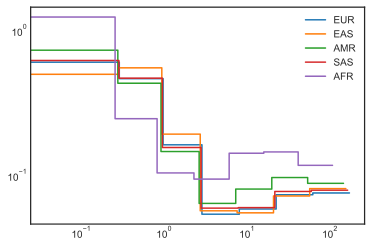

<IPython.core.display.Javascript object>

In [70]:
for pop in estimates:
    estimates[pop].Ne.draw(label=pop)
plt.xscale("log")
plt.yscale("log")
plt.legend()